In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

In [48]:
# Get imputed data
mimic_complete = pd.read_csv("./impute_mimic.csv")
mimic_complete.head(10)

,Unnamed: 0,id,mort_28,age,sex,weight,height,pf_ratio,po2,pco2,...,fio2,hco3,heart_rate,minute_volume,peep,plateau_pressure,respiratory_rate,syst_blood_pressure,diastolic_blood_pressure,peep_regime
0,0,32128372,0.0,75.0,0.0,93.0,168.0,241.944444,130.666667,28.111111,...,50.000000,12.000000,115.408163,8.241111,8.777778,24.333333,18.943662,100.600000,68.200000,0.0
1,1,34100191,0.0,47.0,1.0,127.0,183.0,166.356061,113.076923,34.461538,...,68.500000,12.750000,115.407407,16.628571,7.375000,17.500000,19.857143,99.000000,68.000000,0.0
2,2,38292466,0.0,85.0,1.0,77.5,170.0,224.000000,112.000000,38.000000,...,51.818182,23.000000,70.041667,9.433333,5.000000,22.333333,15.833333,102.000000,46.333333,0.0
3,3,32743332,0.0,85.0,1.0,90.7,170.0,205.714286,72.000000,38.000000,...,36.875000,27.000000,70.480000,7.478571,5.000000,24.000000,18.200000,108.083333,46.208333,0.0
4,4,35009126,1.0,64.0,1.0,70.0,183.0,173.777778,94.666667,38.666667,...,52.500000,21.666667,73.955556,7.050000,5.428571,14.328571,15.016667,103.415094,57.377358,0.0
5,5,38740124,0.0,38.0,1.0,84.1,178.0,345.000000,199.000000,44.000000,...,60.000000,25.500000,102.909091,7.725000,5.750000,18.275128,16.230769,126.181818,78.909091,0.0
6,6,32359580,1.0,69.0,1.0,86.2,185.0,354.723810,213.500000,32.000000,...,66.250000,9.888889,93.500000,10.500000,8.333333,25.500000,23.852941,91.000000,56.363636,0.0
7,7,39880770,0.0,28.0,0.0,120.0,170.0,770.000000,308.000000,35.000000,...,51.111111,25.000000,95.193548,7.842857,5.625000,15.000000,19.526316,112.620690,51.206897,0.0
8,8,37153661,1.0,82.0,0.0,46.3,157.0,140.071429,109.000000,36.000000,...,60.000000,17.500000,96.090909,7.962500,6.250000,19.000000,21.292683,100.000000,46.235294,0.0
9,9,33630048,0.0,70.0,0.0,63.7,157.0,310.000000,126.000000,29.666667,...,50.000000,16.000000,70.720000,6.516667,5.000000,16.500000,16.451613,100.705882,54.470588,0.0


In [49]:
# Create variables to store outcome Y, treatment T, and features X
y = "mort_28"
T = "peep_regime"
X = ["age", "sex", "weight", "height", "pf_ratio", "po2", "pco2", "ph", "driving_pressure", "lung_compliance", "map", "bilirubin", "creatinine", "platelets", "urea", "fio2", "hco3", "heart_rate", "minute_volume", "peep", "plateau_pressure", "respiratory_rate", "syst_blood_pressure", "diastolic_blood_pressure"]
L = ["age", "weight", "pf_ratio", "po2", "driving_pressure", "fio2", "hco3", "plateau_pressure", "respiratory_rate"] 

### Calibration Curve for Propensity-Score Model + Brier-score 

In [50]:
from sklearn.preprocessing import MinMaxScaler

# Perform multiple runs (as train and test set can differ)
prob_true_list = []
prob_pred_list = []
brier_scores = []

# Perform multiple runs
num_experiments = 50
for _ in range(num_experiments):
     train, test = train_test_split(mimic_complete, test_size=0.3, random_state=None)
     
    # Normalizing Data
     normalizer = MinMaxScaler()
     train[L] = normalizer.fit_transform(train[L])
     test[L] = normalizer.fit_transform(test[L])
     
     # Fit propensity score model
     propensity_model = LogisticRegression(solver="lbfgs", max_iter=200, C=1.0, random_state=123)
     propensity_model.fit(train[L], train[T])
     propensity_scores = propensity_model.predict_proba(test[L])[:, 1]
     
     # Collect true and predicted probabilities and compute calibration curve
     prob_true, prob_pred = calibration_curve(test[T], propensity_scores, n_bins=10)
     prob_true_list.append(prob_true)
     
     prob_pred_list.append(prob_pred)   
     
     # Collect brier score
     brier_score = brier_score_loss(test[T], propensity_scores)
     brier_scores.append(brier_score)


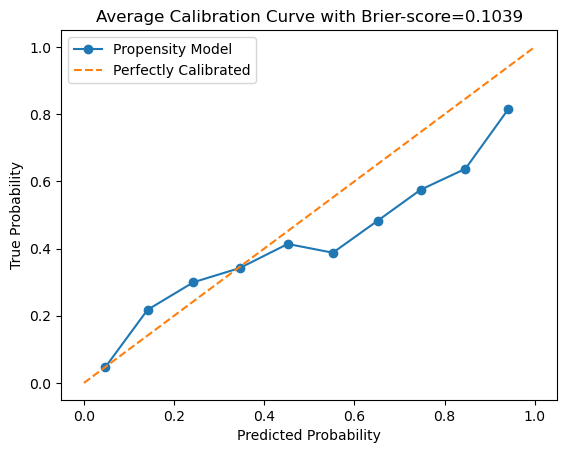

In [61]:
# Make every array of equal length 
max_length = max(len(arr) for arr in prob_true_list + prob_pred_list)
prob_true_list = [np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=np.nan) for arr in prob_true_list]
prob_pred_list = [np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=np.nan) for arr in prob_pred_list]
prob_true_arr = np.array(prob_true_list)
prob_pred_arr = np.array(prob_pred_list)

# Calculate the mean along axis 0 (bins)
avg_prob_true = np.nanmean(prob_true_arr, axis=0)
avg_prob_pred = np.nanmean(prob_pred_arr, axis=0)

# Plot average calibration curve
plt.plot(avg_prob_pred, avg_prob_true, marker='o', label='Propensity Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Average Calibration Curve with Brier-score=0.1039')
plt.legend()
plt.show()

In [52]:
# Calculate Brier loss score --> measures the accuracy of probabilistic predictions (lower Brier is better performance)
avg_brier_score = np.mean(brier_scores)
print(f'Average Brier score: {avg_brier_score:.4f}')

Average Brier score: 0.1039


### Calibration Curve for Calibrated Propensity-Score Model + Brier-score

In [53]:
# Perform multiple runs (as train and test set can differ)
prob_true_list_cal = []
prob_pred_list_cal = []
brier_scores_cal = []

# Perform multiple runs
num_experiments = 100
for _ in range(num_experiments):
     train, test = train_test_split(mimic_complete, test_size=0.2, random_state=None)
     
    # Normalizing Data
     normalizer = MinMaxScaler()
     train[L] = normalizer.fit_transform(train[L])
     test[L] = normalizer.fit_transform(test[L])
     
     # Fit propensity score model
     propensity_model = LogisticRegression(solver="lbfgs", max_iter=200, C=1.0, random_state=123)
     P = ["age", "weight", "pf_ratio", "po2", "driving_pressure", "fio2", "hco3", "plateau_pressure", "respiratory_rate"] 
     propensity_model.fit(train[P], train[T])
     propensity_scores = propensity_model.predict_proba(test[P])[:, 1]
     
     # Use calibration methods (to improve calibation of model)
     calibrated_model = CalibratedClassifierCV(propensity_model, method='isotonic', cv='prefit')
     calibrated_model.fit(train[L], train[T])
     calibrated_scores = calibrated_model.predict_proba(test[L])[:, 1]
     
     # Collect true and predicted probabilities 
     prob_true, prob_pred = calibration_curve(test[T], calibrated_scores, n_bins=10)
     prob_true_list_cal.append(prob_true)
     prob_pred_list_cal.append(prob_pred)   
     
      # Collect brier score
     brier_score = brier_score_loss(test[T], propensity_scores)
     brier_scores_cal.append(brier_score)

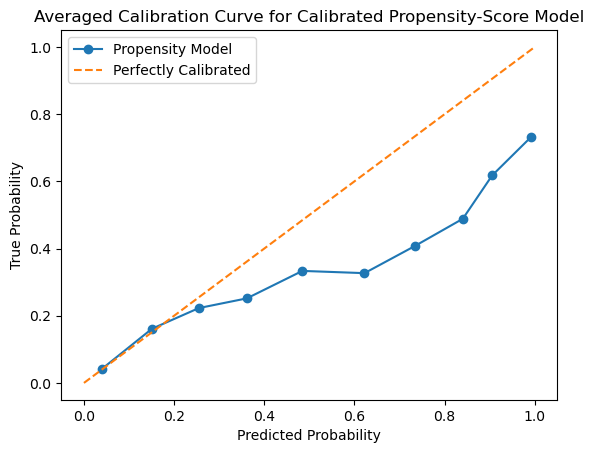

In [54]:
# Make results of equal length
max_length = max(len(arr) for arr in prob_true_list_cal + prob_pred_list_cal)
prob_true_list_cal = [np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=np.nan) for arr in prob_true_list_cal]
prob_pred_list_cal = [np.pad(arr, (0, max_length - len(arr)), mode='constant', constant_values=np.nan) for arr in prob_pred_list_cal]
calibrated_prob_true_arr = np.array(prob_true_list_cal)
calibrated_prob_pred_arr = np.array(prob_pred_list_cal)

# Calculate the mean along axis 0 (bins)
avg_calibrated_prob_true = np.nanmean(calibrated_prob_true_arr, axis=0)
avg_calibrated_prob_pred = np.nanmean(calibrated_prob_pred_arr, axis=0)

# Plot average calibration curve
plt.plot(avg_calibrated_prob_pred, avg_calibrated_prob_true, marker='o', label='Propensity Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Averaged Calibration Curve for Calibrated Propensity-Score Model')
plt.legend()
plt.show()

In [55]:
# Calculate Brier score for the calibrated model
calibrated_brier_score = np.mean(brier_scores_cal)
print(f'Brier score after calibration: {calibrated_brier_score:.4f}')

Brier score after calibration: 0.1117
